## Utils


In [1]:
import pandas as pd

import os
import re
from typing import Dict, List, Tuple

parent_dir = os.path.dirname(os.getcwd())
# date = "10.28"
date = os.path.basename(parent_dir)

save_dir = os.path.join(parent_dir, "tex")

data_dir = os.path.join(parent_dir, "processed_data")


def process_batch_csvs(data_dir: str) -> Tuple[pd.DataFrame, Dict[str, Dict[str, str]]]:
    """
    Process all batch CSV files in the specified directory and combine them into a single DataFrame.
    Also maintains a mapping of batch IDs to their full and short names.

    Args:
        data_dir (str): Path to the directory containing the CSV files

    Returns:
        Tuple[pd.DataFrame, Dict[str, Dict[str, str]]]:
            - Combined DataFrame
            - Dictionary mapping batch IDs to their names and short names
    """
    # Define name mappings
    processor_names = {
        "data_processor": {"full_name": "Data Processor", "short_name": "DP"},
        "model_converter": {"full_name": "Model Converter", "short_name": "MC"},
        "sketch_generator": {"full_name": "Sketch Generator", "short_name": "SG"},
    }

    # Initialize empty list for DataFrames and batch info
    dfs = []
    batch_info = {}

    # Pattern to match files like "clean_data_processor_2117_batch.csv"
    pattern = r"clean_(.+?)_(\d+)_batch\.csv"

    # Process each CSV file in the directory
    for filename in os.listdir(data_dir):
        if filename.startswith("clean_") and filename.endswith("_batch.csv"):
            match = re.match(pattern, filename)
            if match:
                # Extract processor name and batch ID
                processor_type = match.group(1)  # e.g., 'data_processor'
                batch_id = match.group(2)  # e.g., '2117'

                # Read the CSV file
                file_path = os.path.join(data_dir, filename)
                df = pd.read_csv(file_path)

                # Add metadata columns
                df["processor_type"] = processor_type
                df["batch_id"] = batch_id

                dfs.append(df)

                # Store batch information
                if processor_type in processor_names:
                    batch_info[batch_id] = {
                        "processor_type": processor_type,
                        "full_name": processor_names[processor_type]["full_name"],
                        "short_name": processor_names[processor_type]["short_name"],
                    }

    # Combine all DataFrames
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df, batch_info
    else:
        return pd.DataFrame(), {}

### Test Utils


In [2]:
# # Process the files
# combined_df, batch_info = process_batch_csvs(data_dir)

# # Print results
# print("Combined DataFrame shape:", combined_df.shape)
# print("\nBatch Information:")
# for batch_id, info in batch_info.items():
#     print(f"Batch {batch_id}:")
#     print(f"  Processor Type: {info['processor_type']}")
#     print(f"  Full Name: {info['full_name']}")
#     print(f"  Short Name: {info['short_name']}")


# import os

# # Get the current notebook's directory
# current_dir = os.getcwd()
# tex_dir = os.path.join(current_dir, "tex")

# # Get the parent directory
# parent_dir = os.path.dirname(os.getcwd())

# # Get just the name of the parent folder
# parent_folder_name = os.path.basename(parent_dir)

# print(f"tex directory: {tex_dir}")
# print(f"Parent directory: {parent_dir}")
# print(f"Parent folder name: {parent_folder_name}")

# Process the files
combined_df, batch_info = process_batch_csvs(data_dir)

# Print results
print("Combined DataFrame shape:", combined_df.shape)
print("\nBatch Information:")
for batch_id, info in batch_info.items():
    print(f"Batch {batch_id}:")
    print(f"  Processor Type: {info['processor_type']}")
    print(f"  Full Name: {info['full_name']}")
    print(f"  Short Name: {info['short_name']}")

Combined DataFrame shape: (90, 14)

Batch Information:
Batch 2172:
  Processor Type: sketch_generator
  Full Name: Sketch Generator
  Short Name: SG
Batch 2117:
  Processor Type: data_processor
  Full Name: Data Processor
  Short Name: DP
Batch 7121:
  Processor Type: model_converter
  Full Name: Model Converter
  Short Name: MC


## 1. Token: overall, input, output; ave, med, max, min


In [3]:
def calculate_token_statistics(df: pd.DataFrame, column: str) -> Dict[str, float]:
    """
    Calculate statistics for a specific token column.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Name of the column to analyze

    Returns:
        Dict[str, float]: Dictionary containing average, median, max, and min values
    """
    return {
        "average": df[column].mean(),
        "median": df[column].median(),
        "max": df[column].max(),
        "min": df[column].min(),
    }


def analyze_token_consumption(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """
    Analyze token consumption for each processor type.

    Args:
        df (pd.DataFrame): Combined DataFrame with all batch data
        batch_info (Dict): Mapping of batch IDs to processor information

    Returns:
        Dict: Nested dictionary with statistics for each processor and token type
    """
    token_columns = {
        "overall": "total_tokens",
        "input": "prompt_tokens",
        "output": "completion_tokens",
    }

    results = {}

    # Get unique processor types
    processor_types = df["processor_type"].unique()

    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]

        # Get statistics for each token type
        processor_stats = {}
        for token_type, column in token_columns.items():
            processor_stats[token_type] = calculate_token_statistics(
                processor_df, column
            )

        # Use the full name from batch_info for the processor
        # Get the first batch_id for this processor to look up the full name
        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = processor_stats

    return results


def print_token_statistics(statistics: Dict[str, Dict[str, Dict[str, float]]]):
    """
    Print formatted token statistics.

    Args:
        statistics (Dict): Nested dictionary with token statistics
    """
    for processor, token_types in statistics.items():
        print(f"\n{processor}:")
        for token_type, stats in token_types.items():
            print(f"\n  {token_type.capitalize()} Token Consumption:")
            for stat_name, value in stats.items():
                print(f"    {stat_name.capitalize()}: {int(value)}")


def generate_combined_token_latex_table(
    statistics: Dict[str, Dict[str, Dict[str, float]]], date: str, tex_dir: str = "tex"
) -> None:
    """
    Generate a single LaTeX table combining all token statistics.

    Args:
        statistics: Nested dictionary with token statistics
        date: Date string for the file name
        tex_dir: Directory to save the LaTeX file
    """
    # Ensure tex directory exists
    os.makedirs(tex_dir, exist_ok=True)

    # Define the order of stages and their abbreviations
    stage_order = ["Data Processor", "Model Converter", "Sketch Generator"]
    stage_abbr = {
        "Data Processor": "DP",
        "Model Converter": "MC",
        "Sketch Generator": "SG",
    }

    # LaTeX table preamble
    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \resizebox{\textwidth}{!}{%
        \begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{} &
          \multicolumn{4}{c|}{Overall Token} &
          \multicolumn{4}{c|}{Input Token} &
          \multicolumn{4}{c|}{Output Token} \\ \cline{2-13}
        \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} \\ \hline
    """

    # LaTeX table data filling
    latex_data = ""
    token_types = ["overall", "input", "output"]
    for stage in stage_order:
        if stage in statistics:
            abbr = stage_abbr[stage]
            row_data = [abbr]
            for token_type in token_types:
                stats = statistics[stage][token_type]
                row_data.extend(
                    [
                        str(int(stats["average"])),
                        str(int(stats["median"])),
                        str(int(stats["max"])),
                        str(int(stats["min"])),
                    ]
                )
            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"

    # LaTeX table postamble
    latex_postamble = rf"""
        \end{{tabular}}%
        }}
        \caption{{Token consumption details regarding Overall, Input, and Output in three stages. {date}}}
        \label{{tab:token_details_{date}}}
        \end{{table}}
    """

    # Combine all parts
    latex_content = latex_preamble + latex_data + latex_postamble

    # Save to file
    output_file = os.path.join(save_dir, f"tab_token_details_{date}.tex")
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")


# Example usage:
combined_df, batch_info = process_batch_csvs(data_dir)
statistics = analyze_token_consumption(combined_df, batch_info)
generate_combined_token_latex_table(statistics, date)

# print_token_statistics(statistics)

LaTeX table saved to /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/10.28/tex/tab_token_details_10.28.tex


## 2. Cost: overall, input, output; ave, med, max, min


In [4]:
def calculate_cost_statistics(df: pd.DataFrame, column: str) -> Dict[str, float]:
    """
    Calculate cost statistics for a specific column.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Name of the column to analyze

    Returns:
        Dict[str, float]: Dictionary containing average, median, max, and min values
    """
    return {
        "average": df[column].mean(),
        "median": df[column].median(),
        "max": df[column].max(),
        "min": df[column].min(),
    }


def analyze_cost_consumption(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """
    Analyze cost consumption for each processor type.

    Args:
        df (pd.DataFrame): Combined DataFrame with all batch data
        batch_info (Dict): Mapping of batch IDs to processor information

    Returns:
        Dict: Nested dictionary with statistics for each processor and cost type
    """
    cost_columns = {
        "overall": "total_cost",
        "input": "prompt_cost",
        "output": "completion_cost",
    }

    results = {}
    processor_types = df["processor_type"].unique()

    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]
        processor_stats = {}

        for cost_type, column in cost_columns.items():
            processor_stats[cost_type] = calculate_cost_statistics(processor_df, column)

        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = processor_stats

    return results


def generate_combined_cost_latex_table(
    statistics: Dict[str, Dict[str, Dict[str, float]]], date: str, tex_dir: str = "tex"
) -> None:
    """
    Generate a LaTeX table combining all cost statistics.

    Args:
        statistics: Nested dictionary with cost statistics
        date: Date string for the file name
        tex_dir: Directory to save the LaTeX file
    """
    os.makedirs(tex_dir, exist_ok=True)

    stage_order = ["Data Processor", "Model Converter", "Sketch Generator"]
    stage_abbr = {
        "Data Processor": "DP",
        "Model Converter": "MC",
        "Sketch Generator": "SG",
    }

    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \resizebox{\textwidth}{!}{%
        \begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{} &
          \multicolumn{4}{c|}{Overall Cost (USD cents)} &
          \multicolumn{4}{c|}{Input Cost (USD cents)} &
          \multicolumn{4}{c|}{Output Cost (USD cents)} \\ \cline{2-13}
        \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} \\ \hline
    """

    latex_data = ""
    cost_types = ["overall", "input", "output"]
    for stage in stage_order:
        if stage in statistics:
            abbr = stage_abbr[stage]
            row_data = [abbr]
            for cost_type in cost_types:
                stats = statistics[stage][cost_type]
                # Format costs to 4 decimal places
                row_data.extend(
                    [
                        f"{100 * stats['average']:.2f}",
                        f"{100 * stats['median']:.2f}",
                        f"{100 * stats['max']:.2f}",
                        f"{100 * stats['min']:.2f}",
                    ]
                )
            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"

    latex_postamble = rf"""
        \end{{tabular}}%
        }}
        \caption{{Cost details regarding Overall, Input, and Output in three stages. {date}}}
        \label{{tab:cost_details_{date}}}
        \end{{table}}
    """

    latex_content = latex_preamble + latex_data + latex_postamble

    output_file = os.path.join(save_dir, f"tab_cost_details_{date}.tex")
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")


# Example usage:
combined_df, batch_info = process_batch_csvs(data_dir)
cost_statistics = analyze_cost_consumption(combined_df, batch_info)
generate_combined_cost_latex_table(cost_statistics, date)

LaTeX table saved to /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/10.28/tex/tab_cost_details_10.28.tex


## 3. Time and Token: overall, input, output; ave, max, min


In [5]:
def calculate_basic_statistics(df: pd.DataFrame, column: str) -> Dict[str, float]:
    """Calculate average, max, and min for a given column."""
    return {
        "average": df[column].mean(),
        "max": df[column].max(),
        "min": df[column].min(),
    }


def calculate_success_rate(df: pd.DataFrame) -> float:
    """Calculate success rate from status column."""
    total_count = len(df)
    success_count = len(df[df["status"] == "success"])
    return (success_count / total_count) * 100 if total_count > 0 else 0


def analyze_performance_metrics(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """Analyze execution time, token consumption, and success rate for each processor."""
    results = {}
    processor_types = df["processor_type"].unique()

    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]
        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]

        results[full_name] = {
            "execution_time": calculate_basic_statistics(processor_df, "latency"),
            "token_consumption": calculate_basic_statistics(
                processor_df, "total_tokens"
            ),
            "success_rate": calculate_success_rate(processor_df),
        }

    return results


def generate_performance_latex_table(
    statistics: Dict[str, Dict[str, Dict[str, float]]], date: str, tex_dir: str = "tex"
) -> None:
    """Generate LaTeX table for performance metrics."""
    os.makedirs(tex_dir, exist_ok=True)

    stage_order = ["Data Processor", "Model Converter", "Sketch Generator"]
    stage_abbr = {
        "Data Processor": "DP",
        "Model Converter": "MC",
        "Sketch Generator": "SG",
    }

    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \resizebox{\textwidth}{!}{%
        \begin{tabular}{|l|r|r|r|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{} &
          \multicolumn{3}{c|}{Execution Time (s)} &
          \multicolumn{3}{c|}{Token Consumption} &
          \multicolumn{1}{c|}{Success} \\ \cline{2-8}
        \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Rate (\%)} \\ \hline
    """

    latex_data = ""
    for stage in stage_order:
        if stage in statistics:
            stats = statistics[stage]
            abbr = stage_abbr[stage]
            row_data = [
                abbr,
                f"{stats['execution_time']['average']:.2f}",
                f"{stats['execution_time']['max']:.2f}",
                f"{stats['execution_time']['min']:.2f}",
                f"{int(stats['token_consumption']['average'])}",
                f"{int(stats['token_consumption']['max'])}",
                f"{int(stats['token_consumption']['min'])}",
                f"{stats['success_rate']/100:.3f}",
            ]
            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"

    latex_postamble = rf"""
        \end{{tabular}}%
        }}
        \caption{{Performance metrics including execution time, token consumption, and success rate in three stages. {date}}}
        \label{{tab:performance_metrics_{date}}}
        \end{{table}}
    """

    latex_content = latex_preamble + latex_data + latex_postamble

    output_file = f"{save_dir}/tab_performance_metrics_{date}.tex"
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")


# Example usage:
combined_df, batch_info = process_batch_csvs(data_dir)
performance_stats = analyze_performance_metrics(combined_df, batch_info)
generate_performance_latex_table(performance_stats, date)

LaTeX table saved to /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/10.28/tex/tab_performance_metrics_10.28.tex


## 4. Ave Time and Token: overall/pass/fail


In [6]:
def calculate_status_metrics(df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    """Calculate metrics for overall, passed, and failed cases."""
    # Overall metrics
    overall_metrics = {
        "execution_time": df["latency"].mean(),
        "total_tokens": df["total_tokens"].mean(),
    }

    # Success metrics
    success_df = df[df["status"] == "success"]
    success_metrics = {
        "execution_time": success_df["latency"].mean(),
        "total_tokens": success_df["total_tokens"].mean(),
    }

    # Error metrics
    error_df = df[df["status"] == "error"]
    if len(error_df) > 0:
        error_metrics = {
            "execution_time": error_df["latency"].mean(),
            "total_tokens": error_df["total_tokens"].mean(),
        }
    else:
        # If no error cases, set metrics to 0
        error_metrics = {
            "execution_time": 0.0,
            "total_tokens": 0.0,
        }

    # Success rate
    total_count = len(df)
    success_rate = (len(success_df) / total_count * 100) if total_count > 0 else 0

    return {
        "overall": overall_metrics,
        "success": success_metrics,
        "error": error_metrics,
        "success_rate": success_rate,
    }


def analyze_status_by_processor(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """Analyze metrics for each processor type."""
    results = {}
    processor_types = df["processor_type"].unique()

    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]
        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = calculate_status_metrics(processor_df)

    return results


def generate_status_latex_table(
    statistics: Dict[str, Dict[str, Dict[str, float]]], date: str, tex_dir: str = "tex"
) -> None:
    """Generate LaTeX table for status-based metrics."""
    os.makedirs(tex_dir, exist_ok=True)

    stage_order = ["Data Processor", "Model Converter", "Sketch Generator"]
    stage_abbr = {
        "Data Processor": "DP",
        "Model Converter": "MC",
        "Sketch Generator": "SG",
    }

    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \resizebox{\textwidth}{!}{%
        \begin{tabular}{|l|r|r|r|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{} &
          \multicolumn{3}{c|}{Ave Execution Time (s)} &
          \multicolumn{3}{c|}{Ave Total Tokens} &
          \multicolumn{1}{c|}{Success} \\ \cline{2-8}
        \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
          \multicolumn{1}{c|}{Overall} &
          \multicolumn{1}{c|}{Pass} &
          \multicolumn{1}{c|}{Fail} &
          \multicolumn{1}{c|}{Overall} &
          \multicolumn{1}{c|}{Pass} &
          \multicolumn{1}{c|}{Fail} &
          \multicolumn{1}{c|}{Rate (\%)} \\ \hline
    """

    latex_data = ""
    for stage in stage_order:
        if stage in statistics:
            stats = statistics[stage]
            abbr = stage_abbr[stage]
            row_data = [
                abbr,
                f"{stats['overall']['execution_time']:.2f}",
                f"{stats['success']['execution_time']:.2f}",
                f"{stats['error']['execution_time']:.2f}",
                f"{int(stats['overall']['total_tokens'])}",
                f"{int(stats['success']['total_tokens'])}",
                f"{int(stats['error']['total_tokens'])}",
                f"{stats['success_rate']/100:.3f}",
            ]
            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"

    latex_postamble = rf"""
        \end{{tabular}}%
        }}
        \caption{{Performance metrics of passed and failed runs,including execution time, token consumption, and success rate in three stages. {date}}}
        \label{{tab:performance_metrics_ave_{date}}}
        \end{{table}}
    """

    latex_content = latex_preamble + latex_data + latex_postamble

    output_file = f"{save_dir}/tab_performance_metrics_ave_{date}.tex"
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")


# Example usage:
combined_df, batch_info = process_batch_csvs(data_dir)
status_stats = analyze_status_by_processor(combined_df, batch_info)
generate_status_latex_table(status_stats, date)

LaTeX table saved to /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/10.28/tex/tab_performance_metrics_ave_10.28.tex


## 5. Time: ave, med, max, min


In [7]:
def calculate_time_statistics(df: pd.DataFrame) -> Dict[str, float]:
    """Calculate time statistics for a specific processor."""
    return {
        "average": df["latency"].mean(),
        "median": df["latency"].median(),
        "max": df["latency"].max(),
        "min": df["latency"].min(),
    }


def analyze_time_consumption(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, float]]:
    """Analyze time consumption for each processor type."""
    results = {}
    processor_types = df["processor_type"].unique()

    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]
        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = calculate_time_statistics(processor_df)

    return results


def generate_time_latex_table(
    statistics: Dict[str, Dict[str, float]], date: str, tex_dir: str = "tex"
) -> None:
    """Generate LaTeX table for time consumption statistics."""
    os.makedirs(tex_dir, exist_ok=True)

    stage_order = ["Data Processor", "Model Converter", "Sketch Generator"]
    stage_abbr = {
        "Data Processor": "DP",
        "Model Converter": "MC",
        "Sketch Generator": "SG",
    }

    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \begin{tabular}{|l|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{Stages} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} \\ \hline
    """

    latex_data = ""
    for stage in stage_order:
        if stage in statistics:
            stats = statistics[stage]
            abbr = stage_abbr[stage]
            row_data = [
                abbr,
                f"{stats['average']:.2f}",
                f"{stats['median']:.2f}",
                f"{stats['max']:.2f}",
                f"{stats['min']:.2f}",
            ]
            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"

    latex_postamble = rf"""
        \end{{tabular}}
        \caption{{Time consumption (seconds) in three stages. {date}}}
        \label{{tab:time_{date}}}
        \end{{table}}
    """

    latex_content = latex_preamble + latex_data + latex_postamble

    output_file = f"{save_dir}/tab_time_{date}.tex"
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")


# Example usage:
combined_df, batch_info = process_batch_csvs(data_dir)
time_stats = analyze_time_consumption(combined_df, batch_info)
generate_time_latex_table(time_stats, date)

LaTeX table saved to /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/10.28/tex/tab_time_10.28.tex


## 6. Bar chart: time, token; overall, passed, failed;


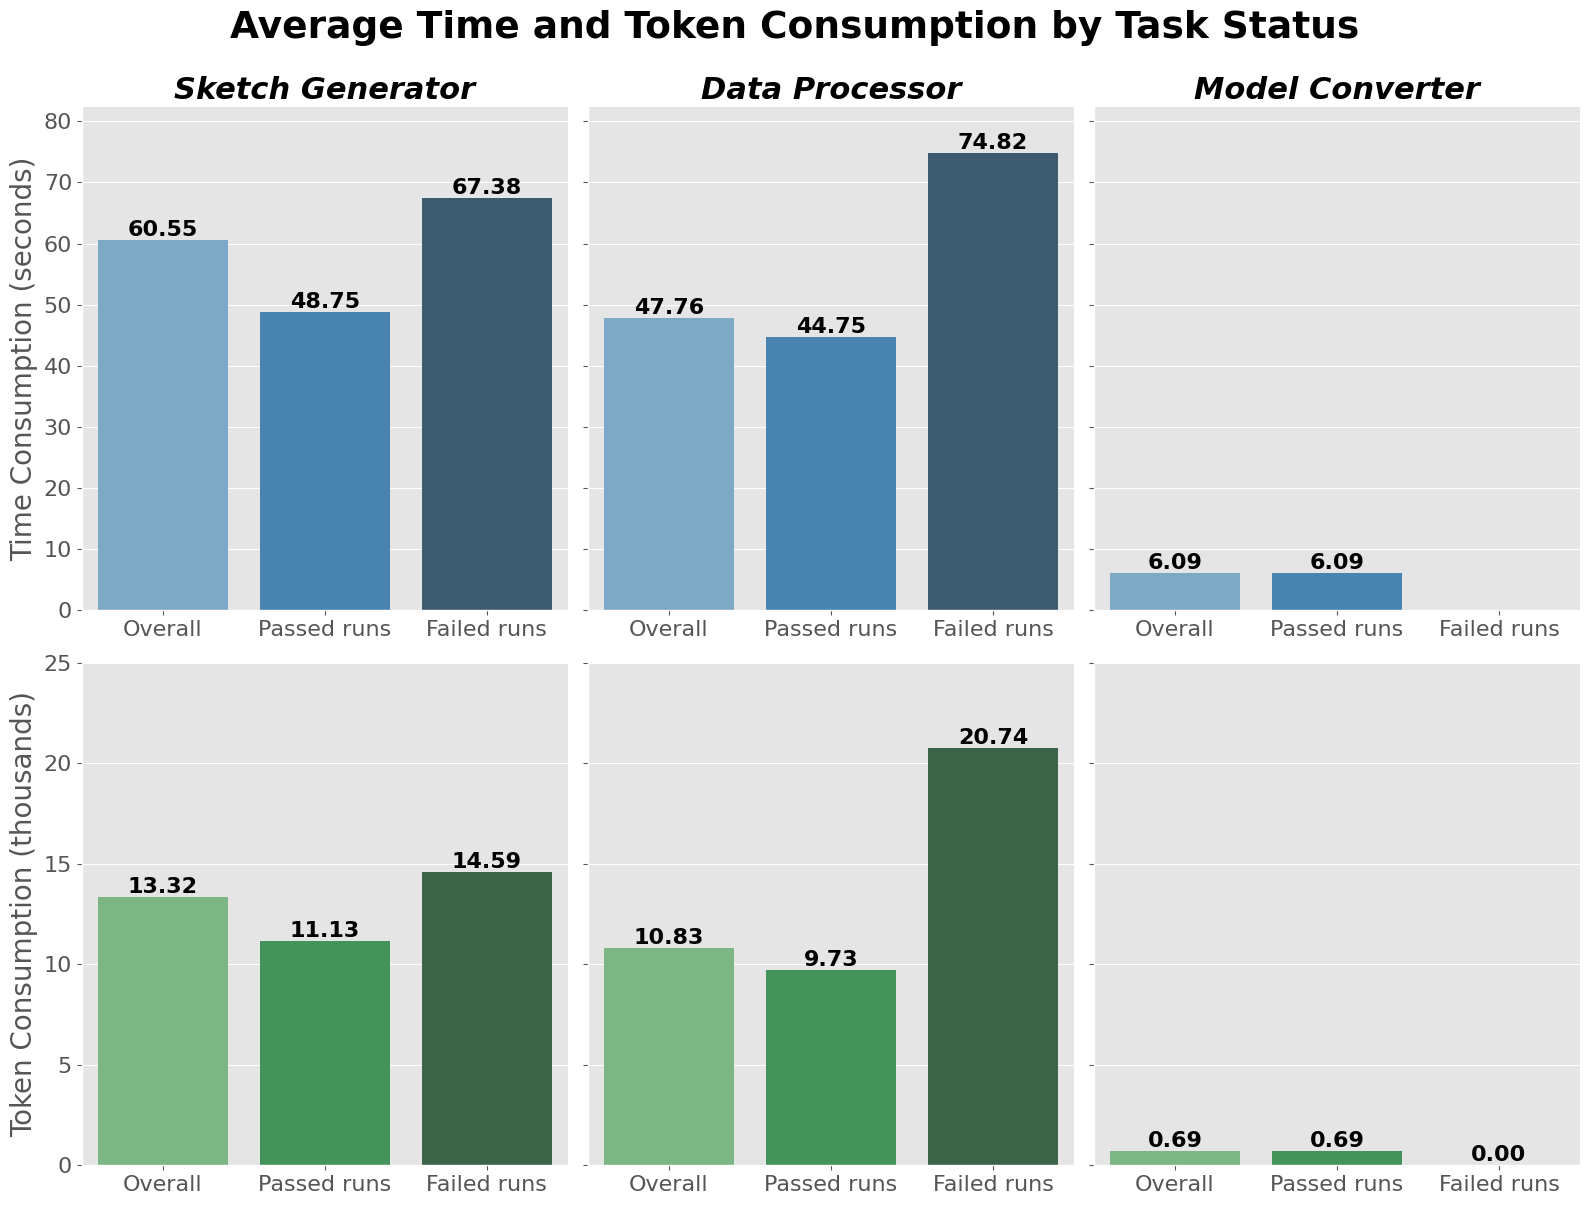

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define plot styling variables
SUPTITLE_SIZE = 27
TITLE_SIZE = 22
TICK_LABEL_SIZE = 16
ANNOTATION_SIZE = 16
AXIS_LABEL_SIZE = 20
FONT_WEIGHT = "bold"


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        return {k: int(v) if not pd.isna(v) else 0 for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["status"] == status]
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def prepare_data_for_plot(df, task_name):
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(df, "success")
    failed_stats = calculate_stats_by_status(df, "error")

    data = []
    for metric in ["latency", "total_tokens"]:
        for status, stats in [
            ("Overall", overall_stats),
            ("Passed runs", passed_stats),
            ("Failed runs", failed_stats),
        ]:
            data.append(
                {
                    "Task": task_name,
                    "Metric": metric,
                    "Status": status,
                    "Average": stats[metric]["average"],
                    "Minimum": stats[metric]["minimum"],
                    "Maximum": stats[metric]["maximum"],
                }
            )
    return pd.DataFrame(data)


# Load data using current workflow
combined_df, batch_info = process_batch_csvs(data_dir)

# Prepare data for each task
task_dfs = {}
for processor_type in combined_df["processor_type"].unique():
    task_df = combined_df[combined_df["processor_type"] == processor_type]
    sample_batch_id = task_df["batch_id"].iloc[0]
    full_name = batch_info[sample_batch_id]["full_name"]
    task_dfs[full_name] = prepare_data_for_plot(task_df, full_name)

# Combine all data
df_all = pd.concat(task_dfs.values())

# Determine global y-axis limits
latency_max = df_all[df_all["Metric"] == "latency"]["Average"].max()
tokens_max = df_all[df_all["Metric"] == "total_tokens"]["Average"].max()

# Set the style
plt.style.use("ggplot")
sns.set_palette("muted")

# Plotting
tasks = df_all["Task"].unique()
fig, axes = plt.subplots(nrows=2, ncols=len(tasks), figsize=(16, 12), sharey="row")
plt.subplots_adjust(top=0.85)

for col, task in enumerate(tasks):
    task_data = df_all[df_all["Task"] == task]

    # Plot latency
    ax_latency = axes[0, col]
    latency_data = task_data[task_data["Metric"] == "latency"]
    sns.barplot(
        x="Status",
        y="Average",
        data=latency_data,
        ax=ax_latency,
        hue="Status",
        palette="Blues_d",
        legend=False,
    )
    ax_latency.set_ylabel(
        "Time Consumption (seconds)" if col == 0 else "", fontsize=AXIS_LABEL_SIZE
    )
    ax_latency.set_ylim(0, latency_max * 1.1)
    ax_latency.set_title(
        task, fontsize=TITLE_SIZE, fontweight=FONT_WEIGHT, style="italic"
    )

    # Annotate latency bars
    for i, bar in enumerate(ax_latency.patches):
        yval = bar.get_height()
        ax_latency.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontweight=FONT_WEIGHT,
            fontsize=ANNOTATION_SIZE,
        )

    # Plot total tokens
    ax_tokens = axes[1, col]
    tokens_data = task_data[task_data["Metric"] == "total_tokens"]
    sns.barplot(
        x="Status",
        y="Average",
        data=tokens_data,
        ax=ax_tokens,
        hue="Status",
        palette="Greens_d",
        legend=False,
    )
    ax_tokens.set_ylabel(
        "Token Consumption (thousands)" if col == 0 else "", fontsize=AXIS_LABEL_SIZE
    )
    ax_tokens.set_ylim(0, tokens_max * 1.1)

    # Set y-axis ticks manually
    y_ticks = ax_tokens.get_yticks()
    ax_tokens.set_yticks(y_ticks)
    ax_tokens.set_yticklabels([f"{int(tick/1000)}" for tick in y_ticks])

    # Annotate token bars
    for i, bar in enumerate(ax_tokens.patches):
        yval = bar.get_height()
        ax_tokens.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval/1000:.2f}",
            ha="center",
            va="bottom",
            fontweight=FONT_WEIGHT,
            fontsize=ANNOTATION_SIZE,
        )

    # Improve readability
    for ax in [ax_latency, ax_tokens]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=TICK_LABEL_SIZE)
        ax.set_xlabel("")

# Add overall title
fig.suptitle(
    "Average Time and Token Consumption by Task Status",
    fontsize=SUPTITLE_SIZE,
    fontweight=FONT_WEIGHT,
    y=1,
)
plt.tight_layout()

# Save and show plot
plt.savefig(
    os.path.join(save_dir, f"bar_plot_{date}.pdf"),
    format="pdf",
    dpi=400,
    bbox_inches="tight",
)
plt.show()

## 7. Scatter plot: time, token; success, error


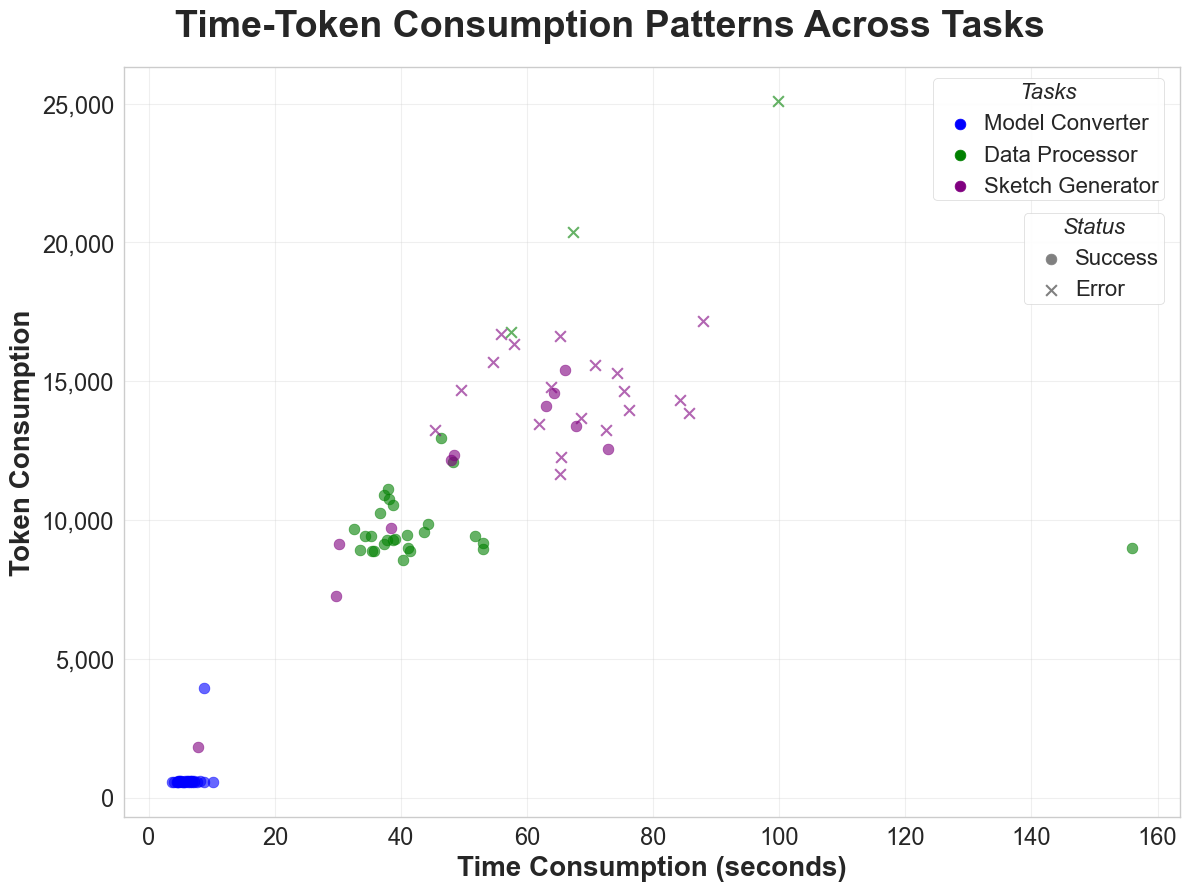

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

# Style parameters
title_fontweight = 800
label_fontweight = 600
tick_fontweight = 400
legend_fontweight = "normal"
legend_fontweight2 = "normal"

title_fontsize = 27
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# Load data using current workflow
combined_df, batch_info = process_batch_csvs(data_dir)

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 9))

# Define colors for each task (using full names from batch_info)
task_colors = {
    "Model Converter": "blue",
    "Data Processor": "green",
    "Sketch Generator": "purple",
}

# Plot each task with different colors and markers
for task_name, color in task_colors.items():
    # Filter data for current task
    task_data = combined_df[
        combined_df["batch_id"].apply(lambda x: batch_info[x]["full_name"] == task_name)
    ]

    # Plot successful runs
    success = task_data[task_data["status"] == "success"]
    plt.scatter(
        success["latency"],
        success["total_tokens"],
        color=color,
        alpha=0.6,
        label=task_name,
        marker="o",
        s=60,
    )

    # Plot failed runs
    failed = task_data[task_data["status"] == "error"]
    plt.scatter(
        failed["latency"],
        failed["total_tokens"],
        color=color,
        alpha=0.6,
        marker="x",
        s=60,
    )

# Labels and title
plt.xlabel(
    "Time Consumption (seconds)", fontsize=label_fontsize, fontweight=label_fontweight
)
plt.ylabel("Token Consumption", fontsize=label_fontsize, fontweight=label_fontweight)
plt.title(
    "Time-Token Consumption Patterns Across Tasks",
    fontsize=title_fontsize,
    loc="center",
    x=0.46,
    y=1.03,
    fontweight=title_fontweight,
)
plt.tick_params(axis="both", which="major", labelsize=17)

# Format axis numbers
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Create legend handles
task_handles = []
task_labels = []
status_handles = []
status_labels = []

# Collect task handles and labels
for task, color in task_colors.items():
    task_handles.append(plt.scatter([], [], color=color, marker="o", s=60))
    task_labels.append(task)

# Add status handles and labels
status_handles.append(plt.scatter([], [], color="gray", marker="o", s=60))
status_handles.append(plt.scatter([], [], color="gray", marker="x", s=60))
status_labels.extend(["Success", "Error"])

legend_title_prop = {
    "weight": legend_fontweight,
    "size": legend_fontsize,
    "style": "italic",
}

# Create legends
first_legend = plt.legend(
    task_handles,
    task_labels,
    loc="upper right",
    bbox_to_anchor=(0.995, 1.0),
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Tasks",
    title_fontproperties=legend_title_prop,
)

# Add the second legend for status markers
plt.gca().add_artist(first_legend)
plt.legend(
    status_handles,
    status_labels,
    loc="upper right",
    bbox_to_anchor=(0.995, 0.82),
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Status",
    title_fontproperties=legend_title_prop,
)

# Finishing touches
plt.grid(True, linestyle="-", alpha=0.3)
plt.tight_layout()

# Save and show plot
plt.savefig(
    os.path.join(save_dir, f"scatter_plot_{date}.pdf"),
    format="pdf",
    dpi=400,
    bbox_inches="tight",
)
plt.show()